텐서플로의 즉시 실행은 그래프를 생성하지 않고 함수를 바로 실행하는 명령형 프로그래밍 환경입니다. 나중에 실행하기 위해 계산가능한 그래프를 생성하는 대신에 계산값을 즉시 알려주는 연산입니다. 이러한 기능은 텐서플로를 시작하고 모델을 디버깅하는 것을 더욱 쉽게 만들고 불필요한 상용구 코드(boilerplate code) 작성을 줄여줍니다

즉시 실행은 연구와 실험을 위한 유연한 기계학습 플랫폼으로 다음과 같은 기능을 제공합니다:

* 직관적인 인터페이스-코드를 자연스럽게 구조화하고 파이썬의 데이터 구조를 활용. 작은 모델과 작은 데이터를 빠르게 반복
* 손쉬운 디버깅-실행중인 모델을 검토하거나 변경 사항을 테스트해보기 위해서 연산을 직접 호출. 에러 확인을 위해서 표준 파이썬 디버깅 툴을 사용
* 자연스런 흐름 제어-그래프 제어 흐름 대신에 파이썬 제어 흐름을 사용함으로써 동적인 모델 구조의 단순화

In [2]:
import tensorflow as tf

import cProfile

tf.executing_eagerly()

True

# 그래디언트 계산하기

자동 미분은 인공 신경망 훈련을 위한 역전파와 같은 기계학습 알고리즘을 구현하는데 유용합니다. 즉시 실행을 사용하는 동안에는, 나중에 그래디언트를 계산하는 연산을 추적하기 위해 tf.GradientTape을 사용하세요.

즉시 실행 중에 그래디언트를 계산하고 모델 훈련에 이용하기 위해서 tf.GradientTape을 사용할 수 있습니다. 특히 복잡하고 반복적인 훈련인 경우에 더 유용합니다.

매번 실행될 때 서로 다른 연산이 수행될 수 있기 때문에 모든 정방향(forward-pass) 연산은 "tape"에 기록됩니다. 그다음 tape를 거꾸로 돌려 그래디언트를 계산한 후 tape를 폐기합니다. 특정한 tf.GradientTape는 오직 하나의 그래디언트만을 계산할 수 있고 부가적인 호출은 실행중 에러(runtime error)를 발생시킵니다.

In [8]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w * w

grad = tape.gradient(loss, w)
print(grad)  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [9]:
# mnist 데이터 가져오기 및 포맷 맞추기
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [10]:
# 모델 생성
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [13]:
for images, labels in dataset.take(1):
    print("로짓: ", mnist_model(images[0:1]).numpy())
    print("True label :", labels[0:1])

로짓:  [[-0.04847394  0.04646802 -0.02276139  0.01996327  0.03230965  0.0162541
   0.01096627  0.00155237 -0.02542919 -0.03108242]]
True label : tf.Tensor([6], shape=(1,), dtype=int64)


## 반복훈련

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [15]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True) # 모델의 예측

        # 결과의 형태를 확인하기 위해서 단언문 추가
        tf.debugging.assert_equal(logits.shape, (32, 10)) # 결과의 형태가 (batch_size, class_num) 인지 확인

        loss_value = loss_object(labels, logits) # 로스 계산

    loss_history.append(loss_value.numpy().mean()) # 로스 history
    grads = tape.gradient(loss_value, mnist_model.trainable_variables) # loss에서 grad 계산
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables)) # 최적화

In [18]:
def train():
    for epoch in range(3):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print('에포크 {} 종료'.format(epoch))

In [19]:
train()

에포크 0 종료
에포크 1 종료
에포크 2 종료


Text(0, 0.5, 'Loss [entropy]')

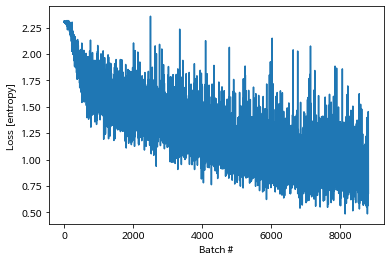

In [20]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

## 변수와 옵티마이저

tf.Variable 객체는 자동 미분을 쉽게 하기 위해서 학습동안 변경된 tf.Tensor 값을 저장합니다. 모델 파라미터는 클래스 인스턴스 변수로 캡슐화될 수 있습니다.

효과적으로 모델 파라미터를 캡슐화하려면 tf.Variable을 tf.GradientTape과 함께 사용합니다. 예를 들어, 위의 자동 미분은 다음과 같이 재작성 가능합니다:

In [22]:
class Model(tf.keras.Model):

    def __init__(self):
        super(Model, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')

    def call(self, inputs):
        return inputs * self.W + self.B


# 약 3 * x + 2개의 점으로 구성된 실험 데이터
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise


# 최적화할 손실함수
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))


def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])


# 정의:
# 1. 모델
# 2. 모델 파라미터에 대한 손실 함수의 미분
# 3. 미분에 기초한 변수 업데이트 전략
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("초기 손실: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# 반복 훈련
for i in range(300):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    if i % 20 == 0:
        print("스텝 {:03d}에서 손실: {:.3f}".format(
            i, loss(model, training_inputs, training_outputs)))

print("최종 손실: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

초기 손실: 69.280
스텝 000에서 손실: 66.568
스텝 020에서 손실: 30.146
스텝 040에서 손실: 13.947
스텝 060에서 손실: 6.741
스텝 080에서 손실: 3.534
스텝 100에서 손실: 2.107
스텝 120에서 손실: 1.472
스텝 140에서 손실: 1.189
스텝 160에서 손실: 1.063
스텝 180에서 손실: 1.007
스텝 200에서 손실: 0.982
스텝 220에서 손실: 0.971
스텝 240에서 손실: 0.966
스텝 260에서 손실: 0.964
스텝 280에서 손실: 0.963
최종 손실: 0.963
W = 3.006845712661743, B = 2.0074503421783447


In [ ]:
if tf.config.experimental.list_physical_devices("GPU"):
    with tf.device("gpu:0"):
        print("GPU 사용 가능")
        v = tf.Variable(tf.random.normal([1000, 1000]))
        v = None  # v는 더이상 GPU 메모리를 사용하지 않음